## Mengambil data dari Google Earth Engine

In [1]:
import ee

# Authenticate to Earth Engine
ee.Authenticate()
ee.Initialize(project='602670742321')

In [2]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


In [50]:
import geemap
import time

# Define the region of interest (ROI)
roi = ee.Geometry.Rectangle([110.0089, -8.2414, 110.8603, -7.4959])

# Define the time range
start_date = '2022-01-01'
end_date = '2022-12-31'

# Create an image collection for Sentinel-2
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(roi) \
    .filterDate(ee.Date(start_date), ee.Date(end_date)) \
    .median()

# Calculate NDVI
ndvi = sentinel2.normalizedDifference(['B4', 'B8']).toFloat().rename('NDVI')  # Convert NDVI to Float32

# Combine Sentinel-2 image with NDVI
sentinel2_with_ndvi = sentinel2.addBands(ndvi)

# Define the export region
export_region = roi

# Define the export parameters
export_params = {
    'image': sentinel2_with_ndvi.toFloat(),  # Convert the entire image to Float32
    'description': 'Sentinel2_with_NDVI_2022',
    'scale': 100,
    'region': export_region,
    'fileFormat': 'GeoTIFF',
    'folder': 'Sentinel2_Export'
}

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

# Monitor the task
while task.status()['state'] in ['READY', 'RUNNING']:
    print(task.status())
    time.sleep(5)

print(task.status())


{'state': 'READY', 'description': 'Sentinel2_with_NDVI_2022', 'priority': 100, 'creation_timestamp_ms': 1715211942174, 'update_timestamp_ms': 1715211942174, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'OEOEGZGIQEANE5CZK3VZ3QQY', 'name': 'projects/602670742321/operations/OEOEGZGIQEANE5CZK3VZ3QQY'}
{'state': 'RUNNING', 'description': 'Sentinel2_with_NDVI_2022', 'priority': 100, 'creation_timestamp_ms': 1715211942174, 'update_timestamp_ms': 1715211944215, 'start_timestamp_ms': 1715211944181, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'OEOEGZGIQEANE5CZK3VZ3QQY', 'name': 'projects/602670742321/operations/OEOEGZGIQEANE5CZK3VZ3QQY'}
{'state': 'RUNNING', 'description': 'Sentinel2_with_NDVI_2022', 'priority': 100, 'creation_timestamp_ms': 1715211942174, 'update_timestamp_ms': 1715211944215, 'start_timestamp_ms': 1715211944181, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'OEOEGZGIQEANE5CZK3VZ3QQY', 'name': 'projects/602670742321/operations/OEOEGZGIQEANE5CZK3VZ3QQY'}
{'

In [4]:
# Install some packages
!pip install rasterio
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.9 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import rasterio
import earthpy.plot as ep
from sklearn.model_selection import train_test_split


In [51]:
# Parameter
CLASSES     = ['Air', 'Lahan Terbangun', 'Vegetasi']
N_CLASSES   = len(CLASSES)
PALETTE     = ['#F08080', '#D2B48C', '#87CEFA']
IMAGE_PATH  = PATH + 'Sentinel2_Export/Sentinel2_with_NDVI_2022.tif'

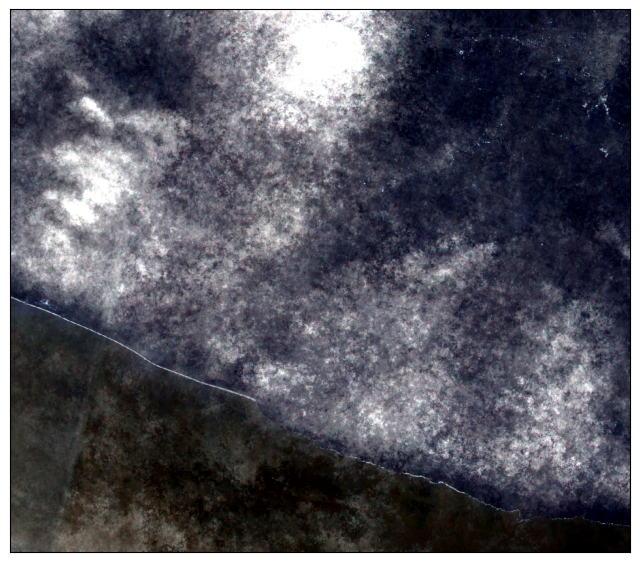

<Axes: >

In [52]:
# Load image
image = rasterio.open(IMAGE_PATH)
# bandNum = image.count
height = image.height
width = image.width
# crs = image.crs
# transform = image.transform
shape = (height, width)

image_vis = []
for x in range(1, len(CLASSES)+1):
    image_vis.append(image.read(x))
image_vis = np.stack(image_vis)


plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [53]:
# Fungsi untuk mengklasifikasikan nilai NDVI
def classify_ndvi(ndvi_values):
    classified_ndvi = np.empty_like(ndvi_values, dtype='object')
    classified_ndvi[(ndvi_values <= 0)] = "Air"
    classified_ndvi[((ndvi_values > 0) & (ndvi_values <= 0.2))] = "Lahan Bangunan"
    classified_ndvi[(ndvi_values > 0.2)] = "Vegetasi"
    return classified_ndvi

# Buka file GeoTIFF
with rasterio.open(IMAGE_PATH) as src:
    # Baca data piksel untuk band B4 dan B8
    nir_band = src.read(1)  # Band 1 corresponds to B4
    red_band = src.read(4)  # Band 4 corresponds to B8

    # Hitung nilai piksel maksimum untuk normalisasi
    max_pixel_value = max(nir_band.max(), red_band.max())

    # Normalisasi nilai piksel B4 dan B8 ke rentang [0, 1]
    nir_band_normalized = nir_band.astype(float) / max_pixel_value
    red_band_normalized = red_band.astype(float) / max_pixel_value

    # Hitung NDVI
    ndvi = (nir_band_normalized - red_band_normalized) / (nir_band_normalized + red_band_normalized)

    # Membatasi hasil NDVI ke rentang -1 hingga 1
    ndvi = ndvi.clip(-1, 1)

    # Klasifikasi NDVI
    classified_ndvi = classify_ndvi(ndvi)

    # Misalnya, Anda dapat mencetak hasilnya
    print(classified_ndvi)


[['Lahan Bangunan' 'Lahan Bangunan' 'Lahan Bangunan' ... 'Lahan Bangunan'
  'Lahan Bangunan' 'Lahan Bangunan']
 ['Lahan Bangunan' 'Lahan Bangunan' 'Lahan Bangunan' ... 'Lahan Bangunan'
  'Lahan Bangunan' 'Lahan Bangunan']
 ['Lahan Bangunan' 'Lahan Bangunan' 'Lahan Bangunan' ... 'Lahan Bangunan'
  'Lahan Bangunan' 'Lahan Bangunan']
 ...
 ['Lahan Bangunan' 'Lahan Bangunan' 'Lahan Bangunan' ... 'Vegetasi'
  'Vegetasi' 'Vegetasi']
 ['Lahan Bangunan' 'Lahan Bangunan' 'Lahan Bangunan' ... 'Vegetasi'
  'Vegetasi' 'Vegetasi']
 ['Lahan Bangunan' 'Lahan Bangunan' 'Lahan Bangunan' ... 'Vegetasi'
  'Vegetasi' 'Vegetasi']]


In [54]:
# Bentuk array data X (gambar) dan Y (label)
X = np.stack((nir_band_normalized.flatten(), red_band_normalized.flatten()), axis=1)  # Stack bands B4 and B8 to create image array
y = classified_ndvi.flatten()  # Flatten the classified NDVI array to create label array

# # Bagi data menjadi set pelatihan dan set pengujian
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Cetak ukuran set pelatihan dan set pengujian
# print("Ukuran set pelatihan (training set):", X_train.shape, y_train.shape)
# print("Ukuran set pengujian (testing set):", X_test.shape, y_test.shape)

In [55]:
from imblearn.under_sampling import RandomUnderSampler

# Reshape input data to 2D
X_reshaped = X.reshape(X.shape[0], -1)

# Initialize RandomUnderSampler
undersample = RandomUnderSampler()

# Fit and apply the transform
X_resampled, y_resampled = undersample.fit_resample(X_reshaped, y)

In [57]:
df = pd.DataFrame(X_resampled)
df.columns = ['B4', 'B8']
df['label'] = y_resampled
df.to_csv(PATH + 'data_2022.csv', index=False)
df

,B4,B8,label
0,0.778086,0.778671,Air
1,0.702264,0.713514,Air
2,0.656026,0.659021,Air
3,0.669540,0.686340,Air
4,0.466896,0.486158,Air
...,...,...,...
2095,0.443048,0.295164,Vegetasi
2096,0.415267,0.271001,Vegetasi
2097,0.408766,0.255905,Vegetasi
2098,0.405223,0.255625,Vegetasi


Jalankan kode dibawah ini ketika sudah mengunduh data dari 2015-2023

In [60]:
df1 = pd.read_csv(PATH + 'data_2021.csv')
df2 = pd.read_csv(PATH + 'data_2022.csv')
df3 = pd.read_csv(PATH + 'data_2023.csv')
df = pd.concat([df1, df2, df3]).reset_index(drop=True)
df.to_csv(PATH + 'data.csv', index=False)
df

,B4,B8,label
0,0.574496,0.579164,Air
1,0.704630,0.713966,Air
2,0.603622,0.641897,Air
3,0.538835,0.542569,Air
4,0.614824,0.638350,Air
...,...,...,...
6631,0.413294,0.259094,Vegetasi
6632,0.462844,0.296450,Vegetasi
6633,0.420891,0.259971,Vegetasi
6634,0.422790,0.264080,Vegetasi
